<a href="https://colab.research.google.com/github/yolanda-yyy/MealBuddy/blob/main/CIS436M8Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIS436M8Code-Yuying Ying

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Preparation

In [ ]:
# 1. Load the dataset
file_path = 'ecommerce_product_performance.csv'
df = pd.read_csv(file_path)

In [ ]:
# 2. Initial overview
print("Initial data shape:", df.shape)
print("\nData Info:")
print(df.info())
print("\nMissing values per column:\n", df.isnull().mean() * 100)

Initial data shape: (2000, 8)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product_Price       1900 non-null   float64
 1   Discount_Rate       1900 non-null   float64
 2   Product_Rating      1900 non-null   float64
 3   Number_of_Reviews   1900 non-null   float64
 4   Stock_Availability  1900 non-null   float64
 5   Days_to_Deliver     1900 non-null   float64
 6   Return_Rate         1900 non-null   float64
 7   Category_ID         1900 non-null   float64
dtypes: float64(8)
memory usage: 125.1 KB
None

Missing values per column:
 Product_Price         5.0
Discount_Rate         5.0
Product_Rating        5.0
Number_of_Reviews     5.0
Stock_Availability    5.0
Days_to_Deliver       5.0
Return_Rate           5.0
Category_ID           5.0
dtype: float64


In [ ]:
# 3. Handle missing values (median imputation for numeric features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    median = df[col].median()
    df[col] = df[col].fillna(median)

In [ ]:
# 3.2 Verify no missing values remain
print("\nMissing values after imputation:\n", df.isnull().sum())


Missing values after imputation:
 Product_Price         0
Discount_Rate         0
Product_Rating        0
Number_of_Reviews     0
Stock_Availability    0
Days_to_Deliver       0
Return_Rate           0
Category_ID           0
dtype: int64


In [ ]:
# Class distribution
print("Stock Availability Counts")
print(df['Stock_Availability'].value_counts(dropna=False), "\n")

Stock Availability Counts
Stock_Availability
1.0    1816
0.0     184
Name: count, dtype: int64 



In [ ]:
# 4. Feature engineering
# 4.1 Log transform skewed feature: Number_of_Reviews
df['Reviews_Log'] = np.log1p(df['Number_of_Reviews'])

In [ ]:
# 4.2 Create Actual_Price feature
df['Actual_Price'] = df['Product_Price'] * (1 - df['Discount_Rate'])

In [ ]:
# 4.3 One-hot encode Category_ID，save a buckup for later for the convenience of graphing.
df['Category_Orig'] = df['Category_ID']   # save a backup
df = pd.get_dummies(df, columns=['Category_ID'], prefix='Cat', drop_first=True)

In [ ]:
# 4.3 One-hot encode Category_ID，save a buckup for later for the convenience of graphing.
# df = pd.get_dummies(df, columns=['Category_ID'], prefix='Cat', drop_first=True)

### EDA

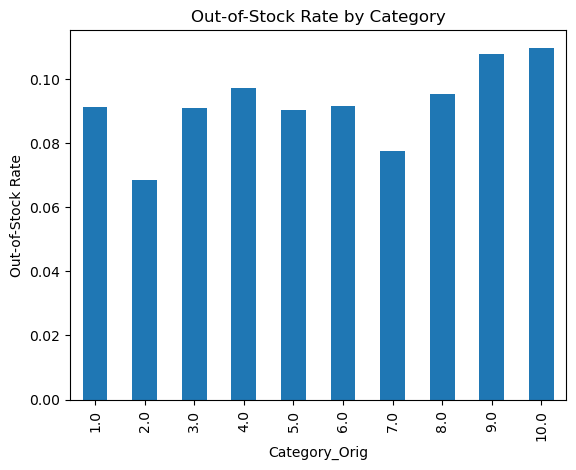

In [ ]:
# 6. Out-of-Stock Rate by Category
# Now group on backup:
stock_out_rate = (
    df.groupby('Category_Orig')['Stock_Availability']
      .apply(lambda x: 1 - x.mean())
      .sort_index())

stock_out_rate.plot(kind='bar')
plt.title('Out-of-Stock Rate by Category')
plt.xlabel('Category_Orig')
plt.ylabel('Out-of-Stock Rate')
plt.show()

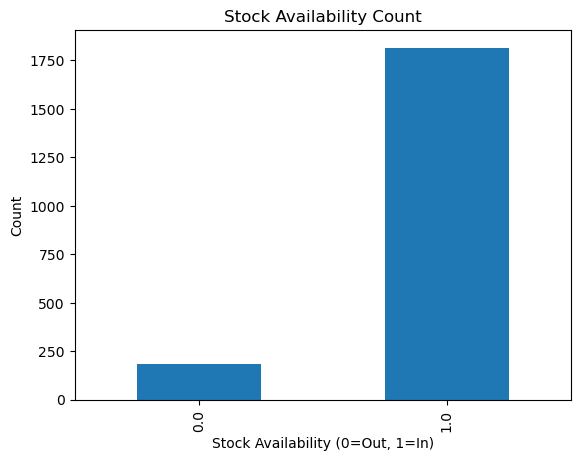

In [ ]:
# 5.2 Stock availability count
plt.figure()
df['Stock_Availability'].value_counts().sort_index().plot(kind='bar')
plt.title('Stock Availability Count')
plt.xlabel('Stock Availability (0=Out, 1=In)')
plt.ylabel('Count')
plt.show()

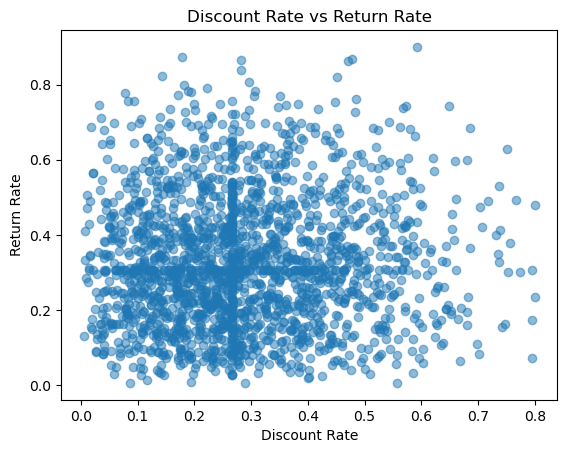

In [ ]:
# 5.3 Scatter: Discount_Rate vs Return_Rate
plt.figure()
plt.scatter(df['Discount_Rate'], df['Return_Rate'], alpha=0.5)
plt.title('Discount Rate vs Return Rate')
plt.xlabel('Discount Rate')
plt.ylabel('Return Rate')
plt.show()

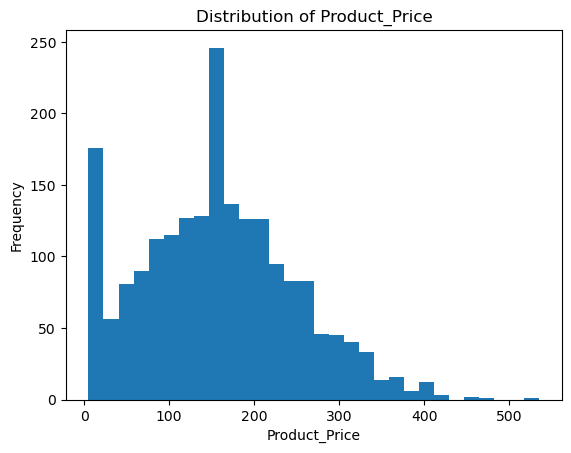

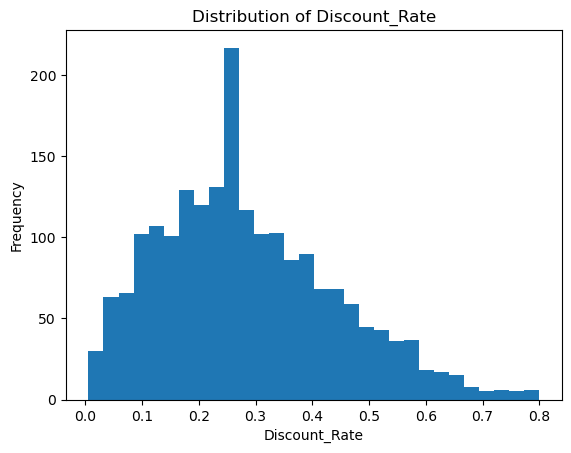

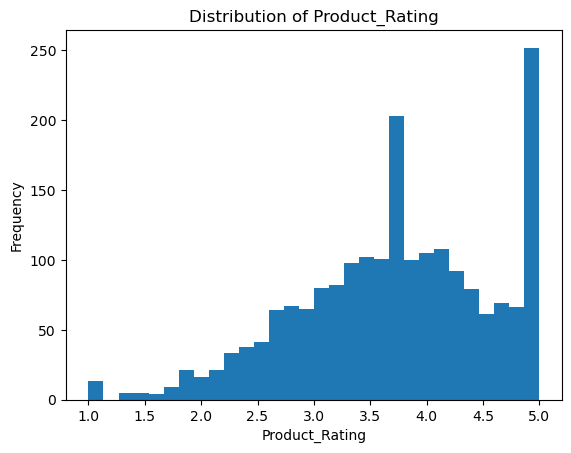

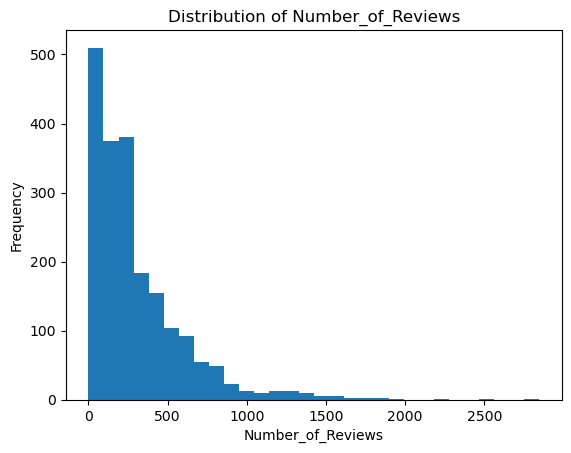

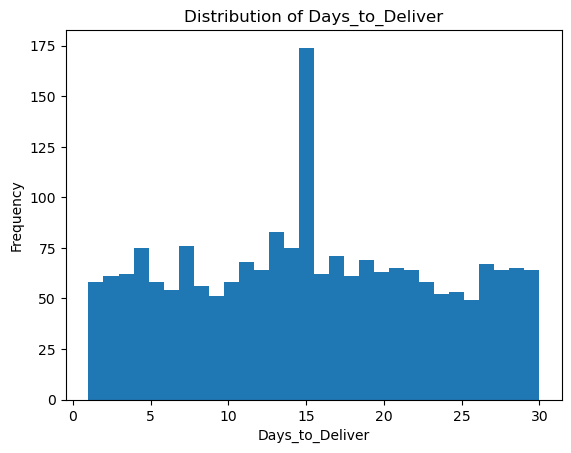

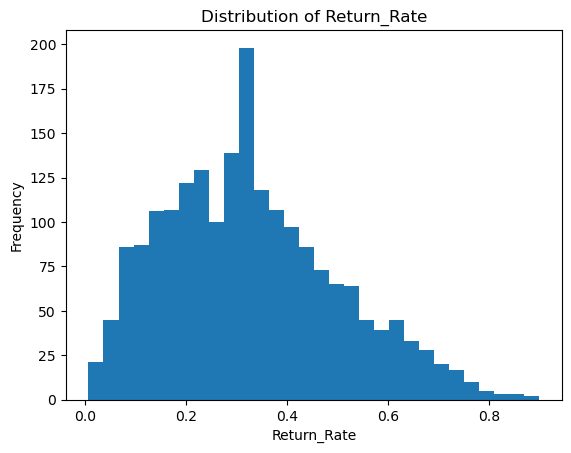

In [ ]:
# 4. Histograms for numeric features
numeric_cols = ['Product_Price', 'Discount_Rate', 'Product_Rating',
                'Number_of_Reviews', 'Days_to_Deliver', 'Return_Rate']
for col in numeric_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

<Figure size 640x480 with 0 Axes>

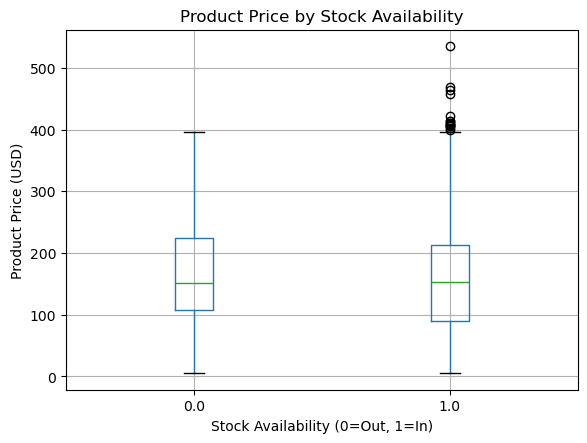

In [ ]:
# 5. Boxplot: Product Price by Stock Availability
plt.figure()
df.boxplot(column='Product_Price', by='Stock_Availability')
plt.title('Product Price by Stock Availability')
plt.suptitle('')
plt.xlabel('Stock Availability (0=Out, 1=In)')
plt.ylabel('Product Price (USD)')
plt.show()

In [ ]:
# 6. Display head of the cleaned and feature-engineered DataFrame

print("Cleaned & Feature-Engineered Data Sample", df.head(10))

Cleaned & Feature-Engineered Data Sample    Product_Price  Discount_Rate  Product_Rating  Number_of_Reviews  \
0     199.671415       0.177024        4.411071               62.0   
1     136.173570       0.041467        3.033534              201.0   
2     214.768854       0.276197        2.866881              479.0   
3     302.302986       0.094254        4.473473              252.0   
4     126.584663       0.411845        3.553082              671.0   
5     126.586304       0.515701        1.874022              303.0   
6     307.921282       0.634228        3.770215              350.0   
7     226.743473       0.271702        3.366010              330.0   
8     103.052561       0.161156        5.000000              179.0   
9     204.256004       0.301962        5.000000              350.0   

   Stock_Availability  Days_to_Deliver  Return_Rate  Reviews_Log  \
0                 1.0              9.0     0.185116     4.143135   
1                 1.0              3.0     0.384639 

### Demand Forecasting & EDA

In [ ]:
import pandas as pd
import numpy as np

# 1) Load original dataset
file_path = 'ecommerce_product_performance.csv'
df = pd.read_csv(file_path)

# 2) Impute missing values (median) for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3) Add daily sales proxy and simulated one-day sales, we do not have these data so estimate one.
df['Daily_Sales_Proxy'] = df['Number_of_Reviews'] / 30.0
np.random.seed(42)
df['Daily_Sales_Simulated'] = np.random.poisson(lam=df['Daily_Sales_Proxy'])

# 4) Inspect the first 10 rows
display("Data with Daily Sales Features (first 10 rows):")
display(df.head(10))
df.to_csv('ecommerce_with_daily_sales.csv', index=False)

'Data with Daily Sales Features (first 10 rows):'

,Product_Price,Discount_Rate,Product_Rating,Number_of_Reviews,Stock_Availability,Days_to_Deliver,Return_Rate,Category_ID,Daily_Sales_Proxy,Daily_Sales_Simulated
0,199.671415,0.177024,4.411071,62.0,1.0,9.0,0.185116,5.0,2.066667,4
1,136.173570,0.041467,3.033534,201.0,1.0,3.0,0.384639,10.0,6.700000,5
2,214.768854,0.276197,2.866881,479.0,1.0,19.0,0.056410,4.0,15.966667,12
3,302.302986,0.094254,4.473473,252.0,1.0,11.0,0.307430,7.0,8.400000,7
4,126.584663,0.411845,3.553082,671.0,1.0,14.0,0.672163,6.0,22.366667,20
5,126.586304,0.515701,1.874022,303.0,1.0,2.0,0.114370,7.0,10.100000,13
6,307.921282,0.634228,3.770215,350.0,1.0,7.0,0.172875,6.0,11.666667,12
7,226.743473,0.271702,3.366010,330.0,1.0,10.0,0.091893,2.0,11.000000,7
8,103.052561,0.161156,5.000000,179.0,1.0,10.0,0.533085,7.0,5.966667,7
9,204.256004,0.301962,5.000000,350.0,1.0,20.0,0.480863,8.0,11.666667,12


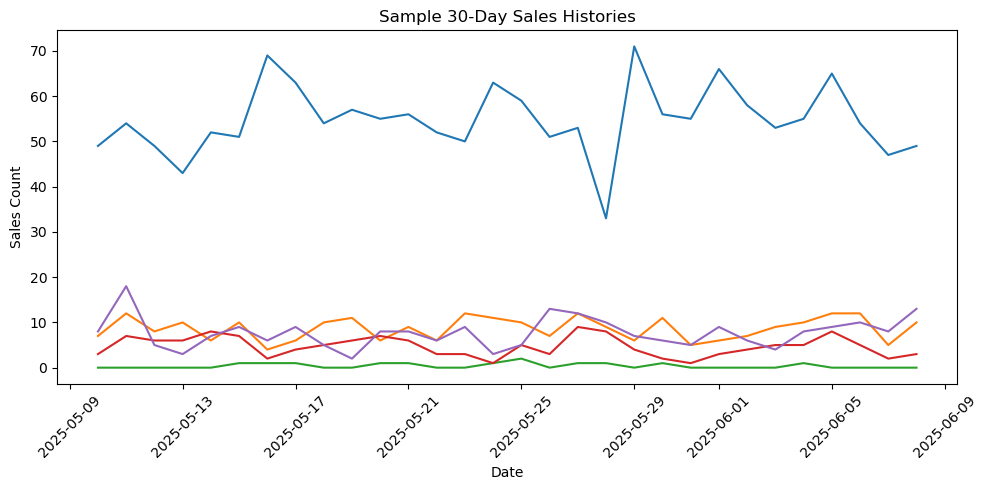

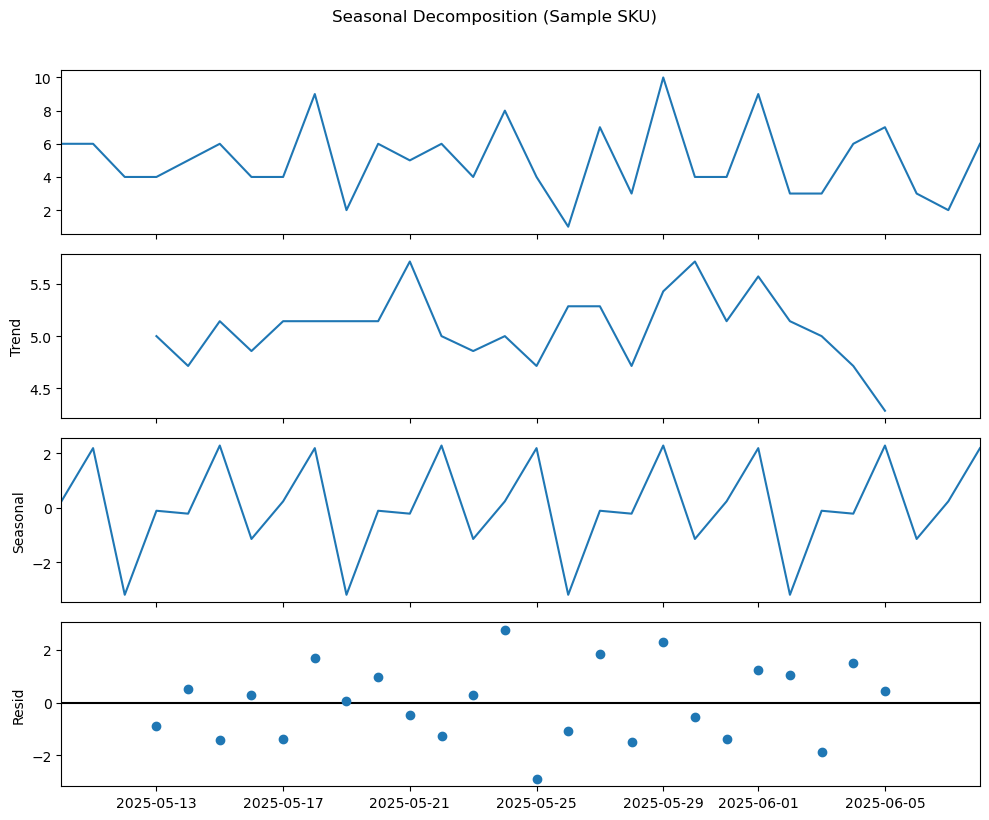

<Figure size 1000x400 with 0 Axes>

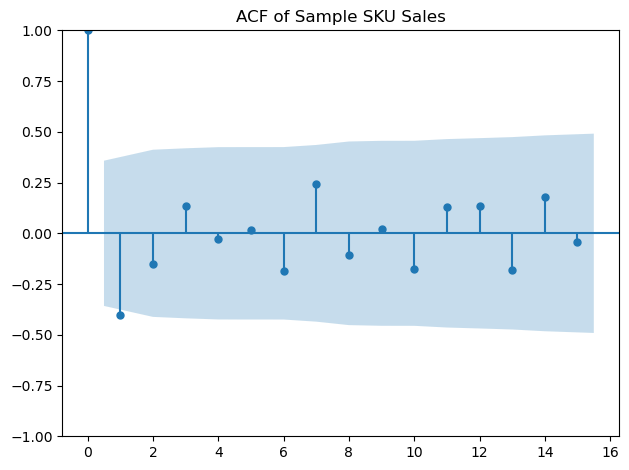

<Figure size 1000x400 with 0 Axes>

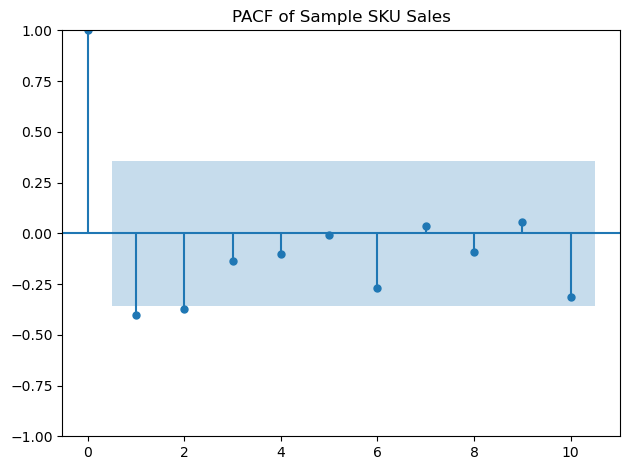

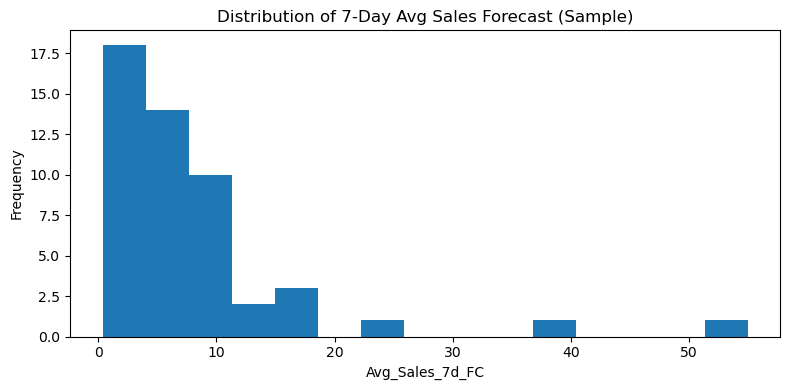

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Load Data
df = pd.read_csv('ecommerce_with_daily_sales.csv')
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Simulate 30-day sales history for a sample of 50 SKUs
np.random.seed(42)
sample_df = df.sample(50, random_state=42).copy()

def make_sales_history(lam, days=30):
    dates = pd.date_range(end=pd.Timestamp.today().normalize(), periods=days, freq='D')
    sales = np.random.poisson(lam=lam, size=days)
    s = pd.Series(sales, index=dates)
    s.index.freq = 'D'
    return s

sample_df['sales_history'] = sample_df['Daily_Sales_Proxy'].map(make_sales_history)

def forecast_avg_7d(history: pd.Series) -> float:
    res = ARIMA(history, order=(1,1,1),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()
    fc = res.get_forecast(7).predicted_mean
    return float(fc.mean())

sample_df['Avg_Sales_7d_FC'] = sample_df['sales_history'].map(forecast_avg_7d)

# 1. Time series plot of 5 random sales histories
plt.figure(figsize=(10, 5))
for history in sample_df['sales_history'].sample(5, random_state=1):
    plt.plot(history.index, history.values)
plt.title('Sample 30-Day Sales Histories')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Seasonal decomposition of the first sample series
series0 = sample_df['sales_history'].iloc[0]
decomp = seasonal_decompose(series0, model='additive', period=7)
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition (Sample SKU)', y=1.02)
plt.tight_layout()
plt.show()

# 3. ACF and PACF of the first sample series
plt.figure(figsize=(10, 4))
plot_acf(series0, lags=15)
plt.title('ACF of Sample SKU Sales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(series0, lags=10, method='ywm')
plt.title('PACF of Sample SKU Sales')
plt.tight_layout()
plt.show()

# 4. Distribution of 7-day average forecast in the sample
plt.figure(figsize=(8, 4))
plt.hist(sample_df['Avg_Sales_7d_FC'], bins=15)
plt.title('Distribution of 7-Day Avg Sales Forecast (Sample)')
plt.xlabel('Avg_Sales_7d_FC')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Methodology

In [ ]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Suppress warnings from ARIMA fitting
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.*")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed.*")

# 1. Load dataset with daily sales proxy
df = pd.read_csv('ecommerce_with_daily_sales.csv')
df['Reviews_Log']  = np.log1p(df['Number_of_Reviews'])
df['Actual_Price'] = df['Product_Price'] * (1 - df['Discount_Rate'])

# 2. Impute missing numeric values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. Simulate a 30-day sales history per SKU
def make_sales_history(lam, days=30):
    dates = pd.date_range(end=pd.Timestamp.today().normalize(), periods=days, freq='D')
    sales = np.random.poisson(lam=lam, size=days)
    s = pd.Series(sales, index=dates)
    s.index.freq = 'D'
    return s

df['sales_history'] = df['Daily_Sales_Proxy'].map(make_sales_history)


np.random.seed(42)
df['Current_Inventory'] = np.random.randint(50, 200, size=len(df))


# 4. Forecast average next-7-day sales
def forecast_avg_7d(history: pd.Series) -> float:
    res = ARIMA(history, order=(1,1,1),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()
    fc = res.get_forecast(7).predicted_mean
    return float(fc.mean())

df['Avg_Sales_7d_FC'] = df['sales_history'].map(forecast_avg_7d)

# 5. Compute EOQ-based signals
z = 1.65  # 95% service level
df['Std_Daily_Sales'] = df['sales_history'].map(lambda s: s.diff().std())
df['Safety_Stock']    = z * df['Std_Daily_Sales'] * np.sqrt(df['Days_to_Deliver'])
df['Avg_Daily_FC']    = df['Avg_Sales_7d_FC'] / 7
df['Reorder_Point']   = df['Avg_Daily_FC'] * df['Days_to_Deliver'] + df['Safety_Stock']
df['Inv_vs_ROP']      = df['Current_Inventory'] - df['Reorder_Point']

# 6. Prepare features and target
feature_cols = [
    'Actual_Price', 'Reviews_Log', 'Discount_Rate',
    'Product_Rating', 'Return_Rate',
    'Avg_Sales_7d_FC', 'Inv_vs_ROP'
]
X = df[feature_cols]
y = df['Stock_Availability'].astype(int)

# 7. Define at least 4 models
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
    'DecisionTree':       DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest':       RandomForestClassifier(n_estimators=2000, class_weight='balanced', random_state=42),
    'MLP':                MLPClassifier(hidden_layer_sizes=(50,30), max_iter=2000, random_state=42)
}

# 8. Cross-validate each model
cv = StratifiedKFold(5, shuffle=True, random_state=42)
results = {}
for name, clf in models.items():
    pipe = Pipeline([('scale', StandardScaler()), ('clf', clf)])
    scores = cross_validate(pipe, X, y, cv=cv,
                            scoring=['precision','recall','f1'],
                            return_train_score=False)
    results[name] = {
        'Precision': np.mean(scores['test_precision']),
        'Recall':    np.mean(scores['test_recall']),
        'F1-score':  np.mean(scores['test_f1'])
    }

# 9. Display results
results_df = pd.DataFrame(results).T
results_df


,Precision,Recall,F1-score
LogisticRegression,0.904044,0.506607,0.648908
DecisionTree,0.908641,0.903645,0.906103
RandomForest,0.908000,1.000000,0.951782
MLP,0.909913,0.945482,0.927341


In [ ]:
# save_model.py
import joblib
from sklearn.pipeline import Pipeline

best_pipe = pipe

joblib.dump(best_pipe, 'stockout_model.pkl')
print("Model saved to stockout_model.pkl")

Model saved to stockout_model.pkl


### Model Results & Visualization

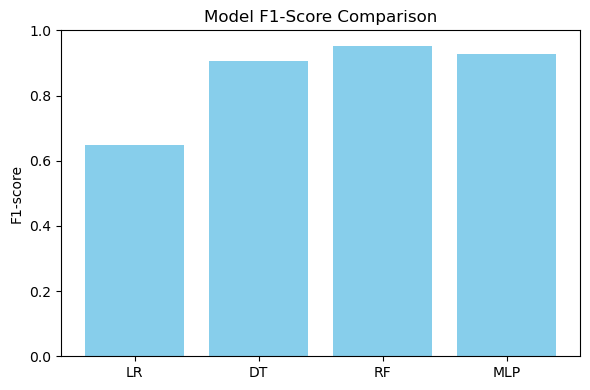

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# results_df
results_df = pd.DataFrame({
    'Precision':[0.904,0.909,0.908,0.909],
    'Recall':   [0.507,0.903,1.000,0.945],
    'F1-score': [0.649,0.906,0.952,0.927]
}, index=['LR','DT','RF','MLP'])

# F1-score comparison
plt.figure(figsize=(6,4))
plt.bar(results_df.index, results_df['F1-score'], color='skyblue')
plt.ylim(0,1)
plt.ylabel('F1-score')
plt.title('Model F1-Score Comparison')
plt.tight_layout()
plt.show()


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.91      1.00      0.95       545

    accuracy                           0.91       600
   macro avg       0.45      0.50      0.48       600
weighted avg       0.83      0.91      0.86       600



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


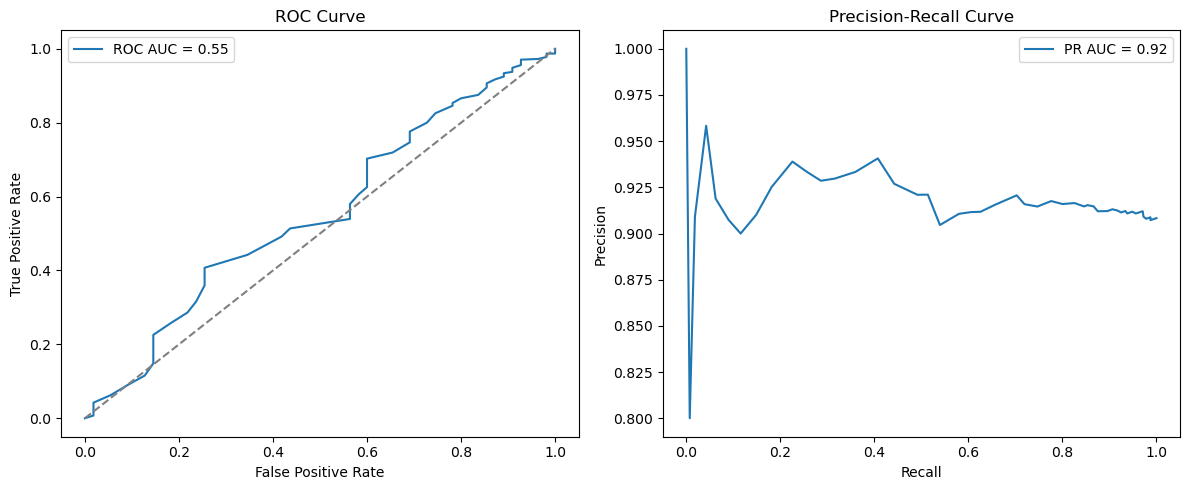

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report

# 1. Split data into train/test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Define and fit RandomForest pipeline
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42))
])
pipe_rf.fit(X_tr, y_tr)

# 3. Classification report on hold-out set
print("Classification Report on Test Set:")
print(classification_report(y_te, pipe_rf.predict(X_te)))

# 4. Compute ROC & PR metrics
probs = pipe_rf.predict_proba(X_te)[:, 1]
fpr, tpr, _ = roc_curve(y_te, probs)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_te, probs)
pr_auc = auc(rec, prec)

# 5. Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
axes[0].plot([0, 1], [0, 1], '--', color='gray')
axes[0].set_title('ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

axes[1].plot(rec, prec, label=f'PR AUC = {pr_auc:.2f}')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()


### Validating Assumptions & Business Impact

In [ ]:
pct = ((df.Inv_vs_ROP<0)&(df.Stock_Availability==0)).mean()
print(f"The out-of-stock ratio is correctly predicted when Inv_vs_ROP<0: {pct:.2%}")


The out-of-stock ratio is correctly predicted when Inv_vs_ROP<0: 1.05%


In [ ]:
# Define a function to compute annual loss and savings
def compute_annual_savings(N, r_base, r_new, P):
    """
    N      : total number of stockout predictions per year
    r_base : recall of baseline model
    r_new  : recall of improved model
    P      : profit lost per missed stockout
    """
    loss_base = (1 - r_base) * N * P
    loss_new  = (1 - r_new) * N * P
    savings   = loss_base - loss_new
    return loss_base, loss_new, savings

# Example usage with placeholder values
N = 10000       # e.g., 10,000 predictions per year
r_base = 0.51   # baseline recall
r_new  = 0.95   # improved model recall
P = 10.0        # $10 profit loss per missed stockout

loss_base, loss_new, savings = compute_annual_savings(N, r_base, r_new, P)

print(f"Baseline Annual Loss: ${loss_base:,.2f}")
print(f"New Model Annual Loss: ${loss_new:,.2f}")
print(f"Annual Savings: ${savings:,.2f}")


Baseline Annual Loss: $49,000.00
New Model Annual Loss: $5,000.00
Annual Savings: $44,000.00


#### The code above defines a function compute_annual_savings that takes:

#### N: total stockout predictions per year

#### r_base: recall of your baseline model

#### r_new: recall of your improved model

#### P: profit lost each time a stockout is missed


![Screenshot 2025-06-08 at 22.13.28.png](attachment:7f2822ac-f89d-4756-ad27-a65b1fccca75.png)

#### Company can plug in their actual values for N, r_base, r_new, and P to quantify the dollar‐value impact of improving recall.